Upload our dataset from my Googledrive.So, we'll Permit this notebook to access my Google Drive files.
Granting access to Google Drive will permit code executed in the notebook to modify files in your Google Drive.

In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [2]:
import pandas as pd
import numpy as np 

import seaborn as sns    # Data visualization
import matplotlib.pyplot as plt # Data visualization
import plotly.express as px  # Data visualization
import missingno as msno # Visualizing missingness 
%matplotlib inline

from scipy.stats import linregress
from sklearn.impute import KNNImputer # for model based imputation

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import r2_score, mean_absolute_error

In [3]:
url="/content/gdrive/MyDrive/MPG/Mileage per gallon.csv"
data=pd.read_csv(url)
data.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,name
0,18.0,8,307.0,130.0,3504,12.0,70,usa,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693,11.5,70,usa,buick skylark 320
2,18.0,8,318.0,150.0,3436,11.0,70,usa,plymouth satellite
3,16.0,8,304.0,150.0,3433,12.0,70,usa,amc rebel sst
4,17.0,8,302.0,140.0,3449,10.5,70,usa,ford torino


In [ ]:
#A bit more information and a summary of our dataset.
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           398 non-null    float64
 1   cylinders     398 non-null    int64  
 2   displacement  398 non-null    float64
 3   horsepower    392 non-null    float64
 4   weight        398 non-null    int64  
 5   acceleration  398 non-null    float64
 6   model_year    398 non-null    int64  
 7   origin        398 non-null    object 
 8   name          398 non-null    object 
dtypes: float64(4), int64(3), object(2)
memory usage: 28.1+ KB


##### As we can see, we've 398 instances, ***one row per car model***.And it seems that the `horsepower` column has ***6 missingness***.

Let's set a global style for our graphs.

In [5]:
sns.set(font_scale=1.5, rc= {'figure.figsize':(8, 6)})
sns.set_style("white")

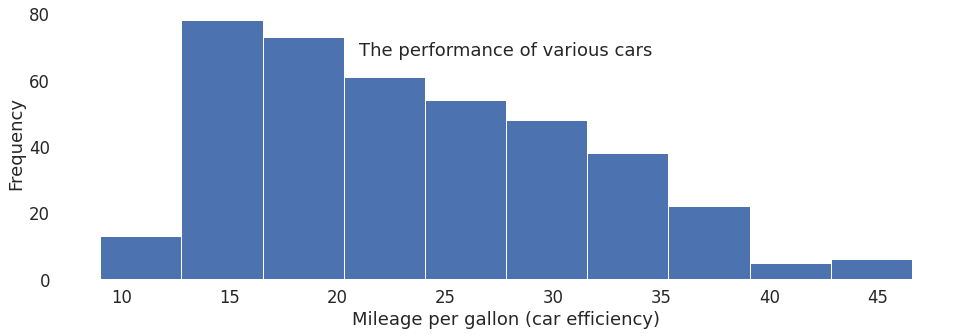

In [6]:
plt.figure(figsize=(16,5))
plt.hist(data["mpg"])
sns.despine(trim=True, left=True, bottom=True)
plt.title("The performance of various cars", y= 0.8)
plt.xlabel("Mileage per gallon (car efficiency)")
plt.ylabel("Frequency")
plt.show()

As we can observe, the distribution of mpg is ***right-skewed***, as longe right tail than the left, which means that there're ***little number of high-efficiency cars*** that drive ***many mileage per gallon*** (burns less amout of fuel).

In [7]:
count= data.origin.value_counts()
count

usa       249
japan      79
europe     70
Name: origin, dtype: int64

The largest portion of cars in our dataset is American made.
<br> For better eye view, let's visualize it.

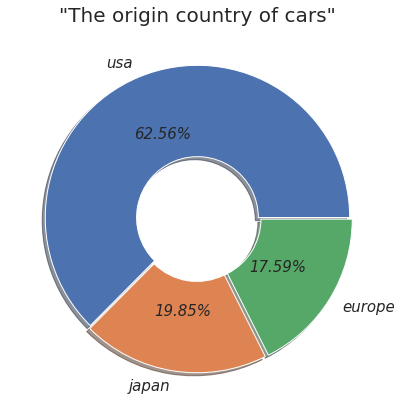

In [8]:
plt.figure(figsize=(18,7))
plt.pie(count, labels=count.index, 
        autopct="%1.2f%%", explode=[0, 0.02,0.02],
        shadow=True, textprops={"fontsize":15, "style":"italic"},
        wedgeprops=dict(width=0.6, edgecolor='w'))
plt.title('"The origin country of cars"', fontsize=20)
plt.show()

The models that you'll be building will depend on the physical characteristics of the cars rather than the model names or manufacturers, so you'll remove the corresponding columns from the data.` [model_year, car_name]`
<br> But they may contain useful information that will help us to get a better intution in analysis.

In [ ]:
print("No. unique cars' names", data.name.nunique(), "\n")
data.name.unique()

No. unique cars' names 305 



array(['chevrolet chevelle malibu', 'buick skylark 320',
       'plymouth satellite', 'amc rebel sst', 'ford torino',
       'ford galaxie 500', 'chevrolet impala', 'plymouth fury iii',
       'pontiac catalina', 'amc ambassador dpl', 'dodge challenger se',
       "plymouth 'cuda 340", 'chevrolet monte carlo',
       'buick estate wagon (sw)', 'toyota corona mark ii',
       'plymouth duster', 'amc hornet', 'ford maverick', 'datsun pl510',
       'volkswagen 1131 deluxe sedan', 'peugeot 504', 'audi 100 ls',
       'saab 99e', 'bmw 2002', 'amc gremlin', 'ford f250', 'chevy c20',
       'dodge d200', 'hi 1200d', 'chevrolet vega 2300', 'toyota corona',
       'ford pinto', 'plymouth satellite custom', 'ford torino 500',
       'amc matador', 'pontiac catalina brougham', 'dodge monaco (sw)',
       'ford country squire (sw)', 'pontiac safari (sw)',
       'amc hornet sportabout (sw)', 'chevrolet vega (sw)',
       'pontiac firebird', 'ford mustang', 'mercury capri 2000',
       'opel 1900'

305 different car model names, but we have obseved that the first name of all car model names is common to many cars. So, we'll extract only the first name of car models.

In [9]:
data["name"]= data["name"].str.split().str.get(0)
data["name"].unique()

array(['chevrolet', 'buick', 'plymouth', 'amc', 'ford', 'pontiac',
       'dodge', 'toyota', 'datsun', 'volkswagen', 'peugeot', 'audi',
       'saab', 'bmw', 'chevy', 'hi', 'mercury', 'opel', 'fiat',
       'oldsmobile', 'chrysler', 'mazda', 'volvo', 'renault', 'toyouta',
       'maxda', 'honda', 'subaru', 'chevroelt', 'capri', 'vw',
       'mercedes-benz', 'cadillac', 'mercedes', 'vokswagen', 'triumph',
       'nissan'], dtype=object)

***Categories and membership constraints (uniqueness constraints).***
categorical data represent variables that represent predefined-finite set of categories. 

[chevrolet, chevroelt, chevy] - [toyota, toyouta] - [mercedes-benz, mercedes] - [volkswagen, vokswagen], [mazda, maxda]
<br>Let's collapsing map categories into fewer ones: reducing categories in categorical column.

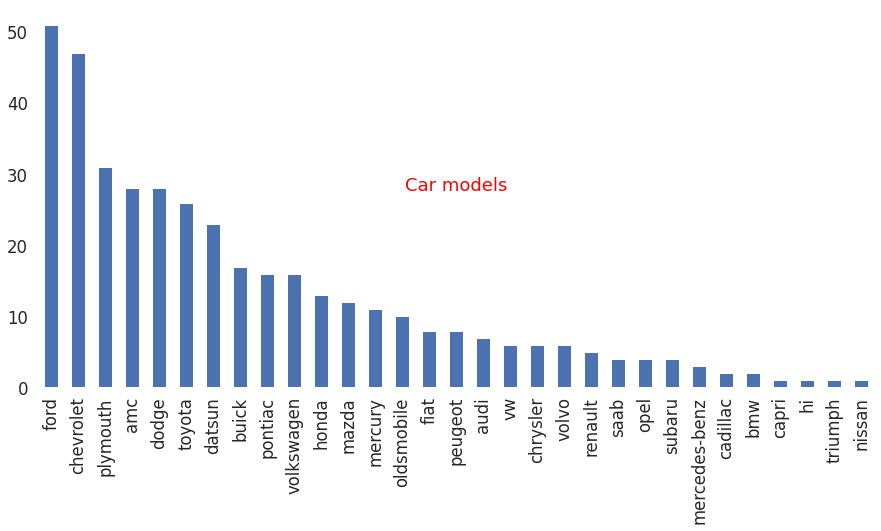

In [13]:
mapping = {'chevy':'chevrolet', 'chevroelt':'chevrolet',  'toyouta':'toyota',
           'mercedes':'mercedes-benz','vokswagen':'volkswagen', "maxda":"mazda"}

data["name"] = data["name"].replace(mapping)
data["name"].value_counts().plot(kind="bar", figsize=(15,7))
plt.title("Car models", y=0.5, color="red")
sns.despine(trim=True, bottom=True, left=True)
plt.show()

Get the relation between origin country and model of cars.

In [ ]:
pd.DataFrame(data.groupby(by="origin").name.value_counts())

name
origin name               
europe volkswagen       16
       fiat              8
       peugeot           8
       audi              7
       volvo             6
       vw                6
       renault           5
       opel              4
       saab              4
       mercedes-benz     3
       bmw               2
       triumph           1
japan  toyota           26
       datsun           23
       honda            13
       mazda            12
       subaru            4
       nissan            1
usa    ford             51
       chevrolet        47
       plymouth         31
       amc              28
       dodge            28
       buick            17
       pontiac          16
       mercury          11
       oldsmobile       10
       chrysler          6
       cadillac          2
       capri             1
       hi                1

Car models differ radically according to the country of manufacture, and this seems logical to a large extent, since in each country there are manufacturers, companies and brands.
<br>For better eye view, let's visualize it using sunbrust from plotly.

In [18]:
plt.figure(figsize=(15,8))
fig= px.sunburst(data, path=['origin', "name"], width=750, height=600, title= "Country and car models")
fig.update_layout(margin=dict(t=0, l=0, r=0, b=0)).update_traces(texttemplate="%{label}<br>%{percentEntry:.2%}")
fig.show()

<Figure size 1080x576 with 0 Axes>

Car models helped us alot to get a better intution in analysis. And here ends the role of car models. So, we're going to drop it, for size reasons and pre-proccessing fro machine learning model.
<br>Breviously we mentioned that our target is to build a predictive model, and the models that you'll be building will depend on the physical characteristics of the cars rather than the model names or manufacturers, not the [model_year, car_name]

In [19]:
data.drop("name", axis=1, inplace=True)

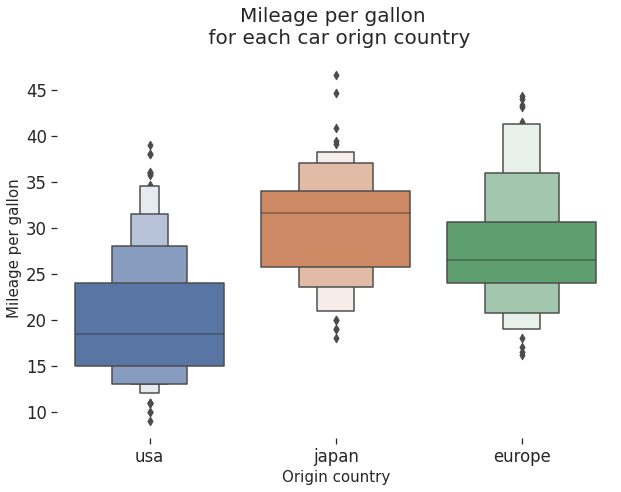

In [ ]:
plt.figure(figsize=(10,7))
sns.boxenplot(data=data, x="origin", y="mpg")
sns.despine(trim= True, bottom=True, left=True)
plt.title("Mileage per gallon \n for each car orign country", y=1.02, fontsize=20)
plt.xlabel("Origin country", fontsize=15)
plt.ylabel("Mileage per gallon", fontsize=15)
plt.show()

***Intersting***! The *** american made cars*** are the ***least efficient*** in our dataset, as they ***drive less mileage per gallon***, which means burning more fuel.
<br> american made cars take values from 9 and up to 39 with little number of outliers.
<br> On average ***japan origin country*** of cars drive ***more mileages-per-gallon***. And it takes values from 18 up to 46 mileage per gallon.
<br>***Let's find out why***.......

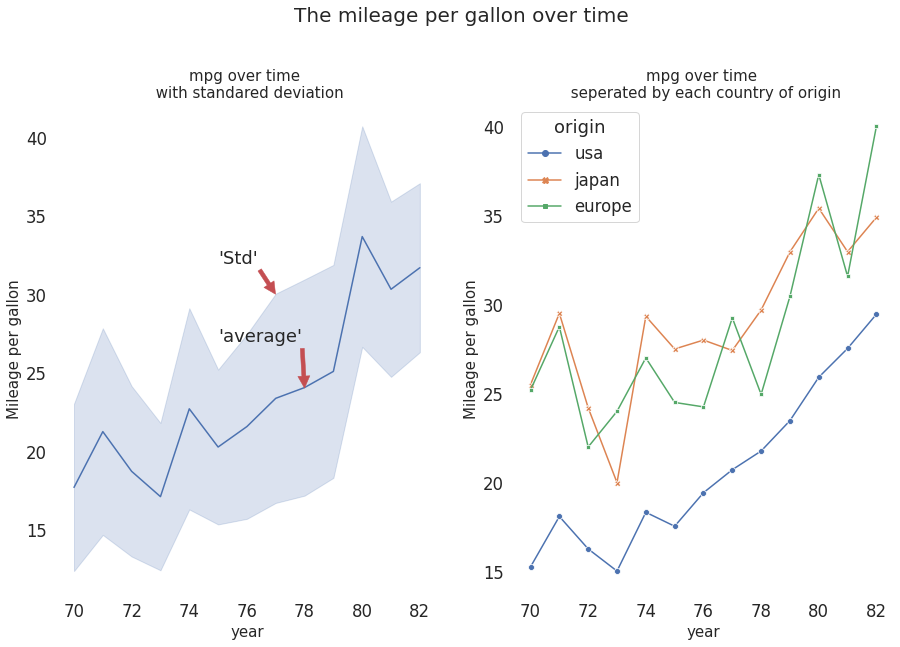

In [25]:
fig , ax=plt.subplots(1,2, figsize=(15,9), sharey=True)
fig.suptitle("The mileage per gallon over time", y=1.03, fontsize=20)

plt.subplot(1,2,1)
sns.lineplot(x="model_year", y="mpg", data=data ,ci="sd")
sns.despine(trim= True, bottom=True, left=True)
plt.title("mpg over time \n with standared deviation", fontsize=15)
plt.ylabel("Mileage per gallon", fontsize=15)
plt.xlabel("year", fontsize=15)

plt.annotate("'Std'", xy=(77,30), xytext=(75,32), arrowprops=dict(color="r", shrink=0.01, lw=0.5))
plt.annotate("'average'", xy=(78,24), xytext=(75,27), arrowprops=dict(color="r", shrink=0.01, lw=0.5))

plt.subplot(1,2,2)
sns.lineplot(data=data, x="model_year", y="mpg", hue="origin", style="origin", ci=None, markers=True, dashes=False)
sns.despine(trim= True, bottom=True, left=True)
plt.title("mpg over time \n seperated by each country of origin", fontsize=15)
plt.ylabel("Mileage per gallon", fontsize=15)
plt.xlabel("year", fontsize=15)

plt.show()

***In the right graph***, we can observe that ***There are some ups and downs***, But ***average miles per gallon*** has ***increased over time***, with ***high standard deviation number***.

***In the left graph*** we can observe that mileage per gallon in cars with the ***USA country origin*** has increased over time, Specially since the beginning of 1975. But ***japan*** and ***europe*** cantry origin is ***randomly distributed*** (ups and downs of mpg over time)

This explains why we have ***high standard deviation number*** in mpg over years.

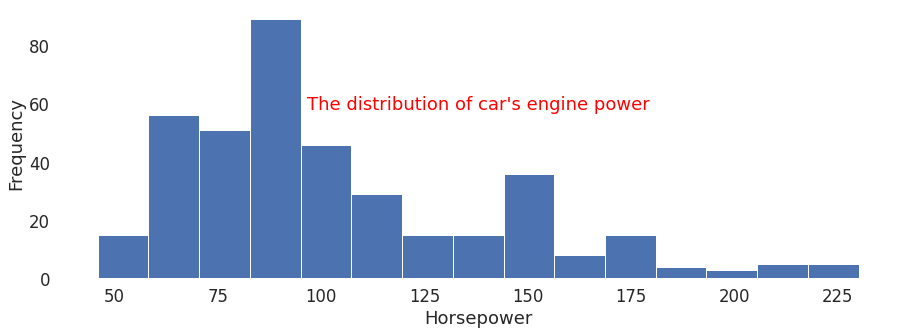

In [22]:
plt.figure(figsize=(15,5))
plt.title("The distribution of car's engine power", y=0.6, color="red")
plt.hist(data["horsepower"], bins=15)
sns.despine(trim= True, bottom=True, left=True)
plt.xlabel("Horsepower")
plt.ylabel("Frequency")
plt.show()

##### ***Right-skewed*** distribution wich means that there're a less cars that have ***high engine power***.

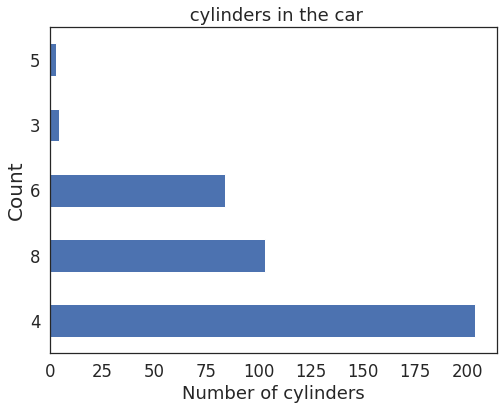

In [23]:
data["cylinders"].value_counts().plot(kind="barh", figsize=(8,6))
plt.title(" cylinders in the car")
plt.xlabel("Number of cylinders")
plt.ylabel("Count",fontsize=20)

plt.show()

##### As we can see ***4 cylinders*** in a car is the most frequent in our dataset.

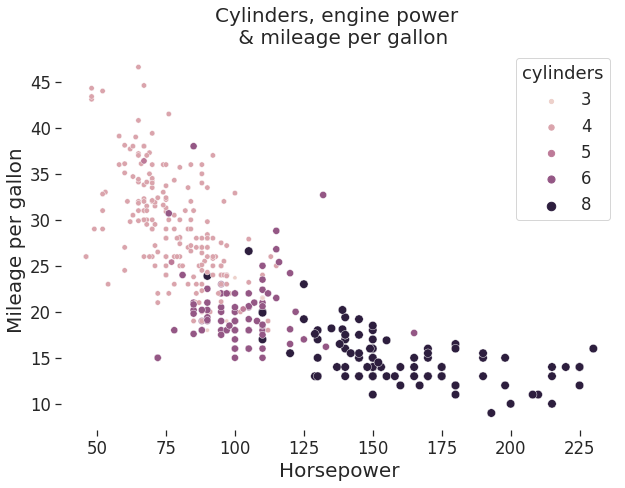

In [ ]:
plt.figure(figsize=(10,7))
sns.scatterplot(data=data, x="horsepower", y="mpg",
            size="cylinders", hue="cylinders")
sns.despine(trim= True, bottom=True, left=True)
plt.title("Cylinders, engine power \n & mileage per gallon", fontsize=20)
plt.xlabel("Horsepower", fontsize=20)
plt.ylabel("Mileage per gallon", fontsize=20)
plt.show()

#### The more increasing of ***cylinders*** and ***car's engine power*** the less ***efficient the car*** is, as It ***burns more fuel*** and drives ***less mileage per gallon***.

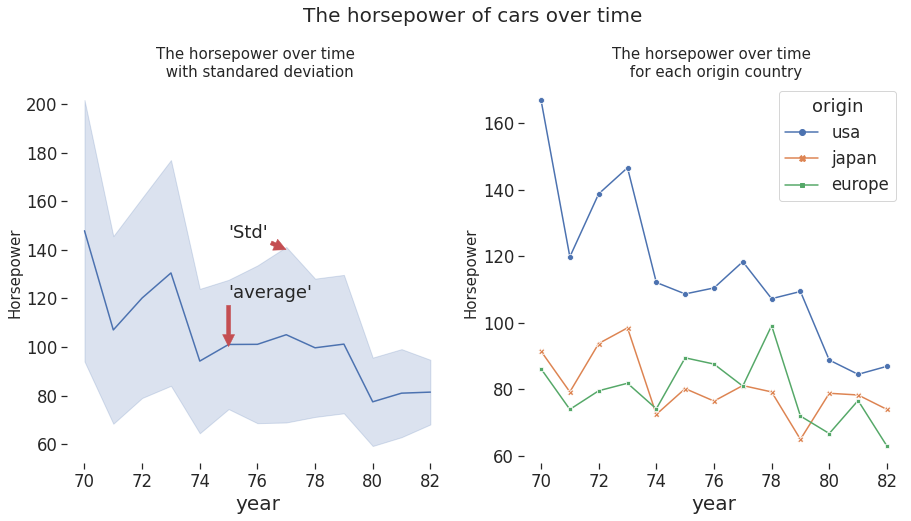

In [ ]:
fig , ax=plt.subplots(1,2, figsize=(15,7))
fig.suptitle("The horsepower of cars over time", y=1.03, fontsize=20)

plt.subplot(1,2,1)
sns.lineplot(x="model_year", y="horsepower", data=data ,ci="sd" )
sns.despine(trim= True, bottom=True, left=True)
plt.title("The horsepower over time \n with standared deviation", fontsize=15)
plt.ylabel("Horsepower", fontsize=15)
plt.xlabel("year", fontsize=20)
plt.annotate("'Std'", xy=(77,140), xytext=(75,145), arrowprops=dict(color="r", shrink=0.01, lw=0.5))
plt.annotate("'average'", xy=(75,100), xytext=(75,120), arrowprops=dict(color="r", shrink=0.01, lw=0.5))

plt.subplot(1,2,2)
sns.lineplot(x="model_year", y="horsepower", 
            data=data, ci=None, style="origin", markers=True,
            dashes=False, hue="origin")
sns.despine(trim= True, bottom=True, left=True)
plt.title("The horsepower over time \n for each origin country", fontsize=15)
plt.ylabel("Horsepower", fontsize=15)
plt.xlabel("year", fontsize=20)

plt.show()

##### In the ***left graph***, we can observe that The ***horsepower*** of  ***usa origin cantry cars*** have ***decreased*** over time with a ***little bit confusion***,
##### this is one of reasons why ***usa cars drives leas mileage per gallon***, as we mentioned earlier the more increase in horsepower the leas mpg is.
##### But ***japan*** and ***europe*** origin country cars have been ***randomly distributed***. and this explains why we have ***high standered deviation nmber*** in horsepower in the ***left graph***.

In [ ]:
relation =data.dropna(subset=["mpg", "horsepower"])
rel = linregress(x=relation["horsepower"], y=relation["mpg"])
print(rel)

LinregressResult(slope=-0.15784473335365348, intercept=39.93586102117045, rvalue=-0.7784267838977758, pvalue=7.031989029405463e-81, stderr=0.006445500517685034)


#### The slope is ***-0.157*** horspower per mpg which means that we expect cars with ***one more horsepower*** unite, will drive mpg at a ***lower rate***, less 0.156 mileage per gallon, as it burns more fuel.

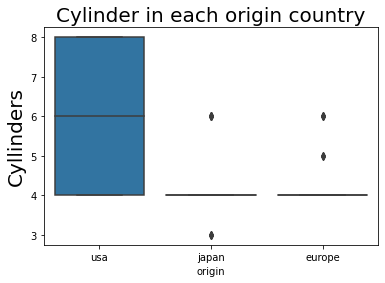

In [ ]:
sns.boxplot(data=data, x="origin", y="cylinders")
plt.title("Cylinder in each origin country", fontsize=20)
plt.ylabel("Cyllinders", fontsize=20)
plt.show()

#### Anther reason of why ***usa cars*** drive leas mileage per gallon is the number of cylinders. As we mentioned before in the cell above, the more increase of cylinders the leas mpg.

In [ ]:
rel = linregress(x=data["cylinders"], y=data["mpg"])
print(rel)

LinregressResult(slope=-3.562886584408225, intercept=42.94931350439763, rvalue=-0.7753962854205542, pvalue=4.503992246177728e-81, stderr=0.14580983196293157)


#### The slope is ***-3.56*** cylinder per mpg which means that we expect cars with one more cylinder, will drive mpg ***at lower rate, The higher the number of cylinders with one more, the less the number of miles per gallon with 3.57.

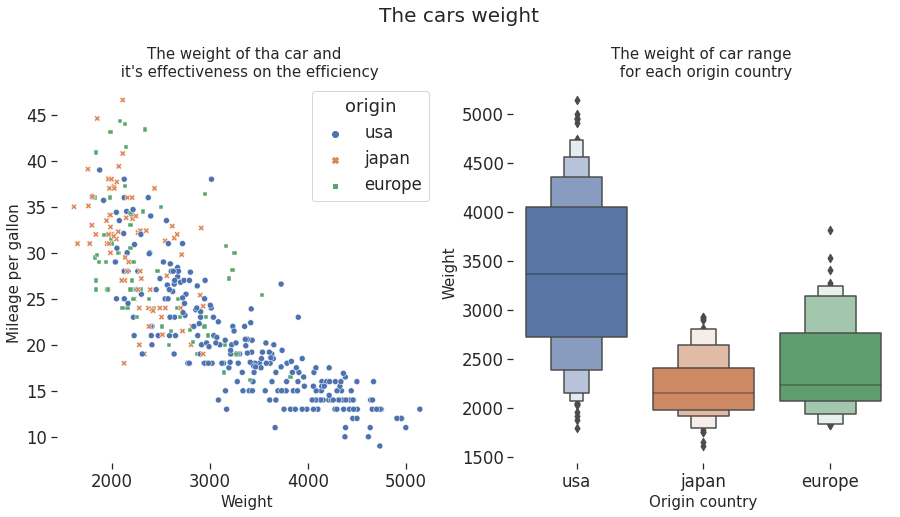

In [ ]:
fig , ax=plt.subplots(1,2, figsize=(15,7))
fig.suptitle("The cars weight ", y=1.03, fontsize=20)

plt.subplot(1,2,1)
sns.scatterplot( data=data, x="weight", y="mpg", hue="origin", style="origin")
sns.despine(trim= True, bottom=True, left=True)
plt.title("The weight of tha car and \n it's effectiveness on the efficiency", fontsize=15)
plt.xlabel("Weight", fontsize=15)
plt.ylabel("Mileage per gallon", fontsize=15)

plt.subplot(1,2,2)
sns.boxenplot( data=data, x="origin", y="weight" )
sns.despine(trim= True, bottom=True, left=True)
plt.title("The weight of car range \n for each origin country", fontsize=15)
plt.xlabel("Origin country", fontsize=15)
plt.ylabel("Weight", fontsize=15)

plt.show()

#### AS we can observe, The more ***heavier*** the car, ***the less effient*** it is, as it ***burns more fuel*** and drives ***less mileage per gallon***.
#### ***Anther reason***, that makes usa cars ***leas efficient***. as we can observe that all cars that have heavy weight ars with usa origin country. as usa cars takes from 1800 upto 5140 wieght, which is more heavier than japan and europe.

In [ ]:
relation = linregress(x=data["weight"], y=data["mpg"])
print(relation)

LinregressResult(slope=-0.007676610063926469, intercept=46.31736442026564, rvalue=-0.8317409332443352, pvalue=2.9727995640493384e-103, stderr=0.0002574868628078228)


The slope is 0.007, which means that The more car weigt by 1, the less number of miles per gallon by 0.007.

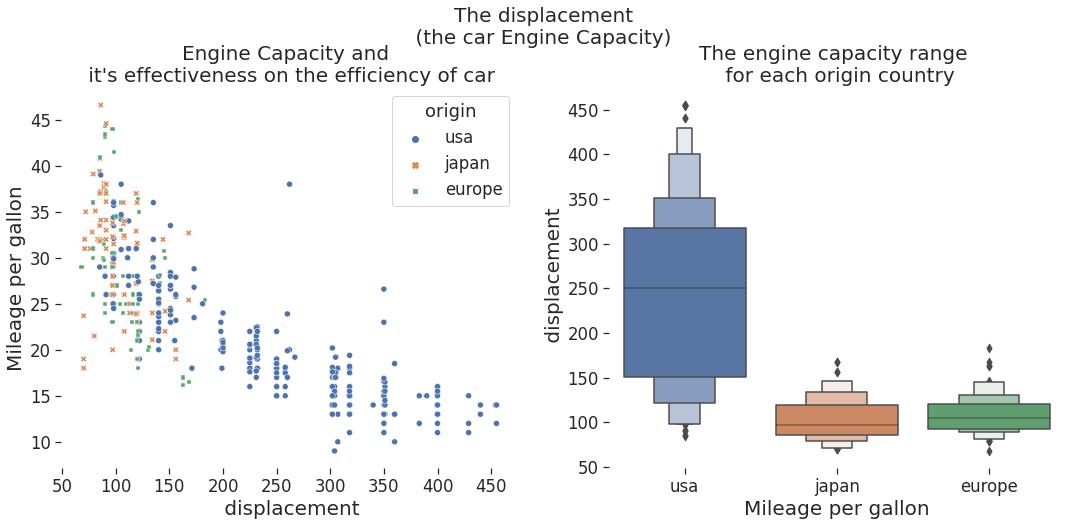

In [ ]:
fig , ax=plt.subplots(1,2, figsize=(18,7))
fig.suptitle("The displacement \n (the car Engine Capacity)  ", y=1.04, fontsize=20)

plt.subplot(1,2,1)
sns.scatterplot( data=data, x="displacement", y="mpg", hue="origin", style="origin")
sns.despine(trim= True, bottom=True, left=True)
plt.title("Engine Capacity and \n it's effectiveness on the efficiency of car", fontsize=20)
plt.xlabel(" displacement", fontsize=20)
plt.ylabel("Mileage per gallon", fontsize=20)

plt.subplot(1,2,2)
sns.boxenplot( data=data, x="origin", y="displacement" )
sns.despine(trim= True, bottom=True, left=True)
plt.title("The engine capacity range \n for each origin country", fontsize=20)
plt.xlabel("Mileage per gallon", fontsize=20)
plt.ylabel(" displacement", fontsize=20)

plt.show()

#### the more ***increasing*** in ***engine capacity*** in the car the ***leas efficient*** it is, as it ***burs more fuel*** and drives ***leas mileage per gallon***.
#### ***One more reason*** that makes ***usa cars*** in our dataset ***leas efficient***, as we can observe that all cars that has ***high engine capacity*** are usa origin country. as, The diplacement of usa origin country of cars takes  ***from 85 upto 455*** which is ***very large scale*** in ***comparing to japan and europe***, most of it is ***150 up to 320*** which is more havier than ***japan*** and ***europ*** origin country of cars where europe taks from ***68 upto 133*** and japan taks from ***70 upto 168.***

In [ ]:
relation = linregress(x=data["displacement"], y=data["mpg"])
print(relation)

LinregressResult(slope=-0.0602824054688172, intercept=35.174750154293186, rvalue=-0.804202824805898, pvalue=1.655888910192828e-91, stderr=0.002238841129709922)


#### the more displacement by 1, the less mpg by 0.0602.

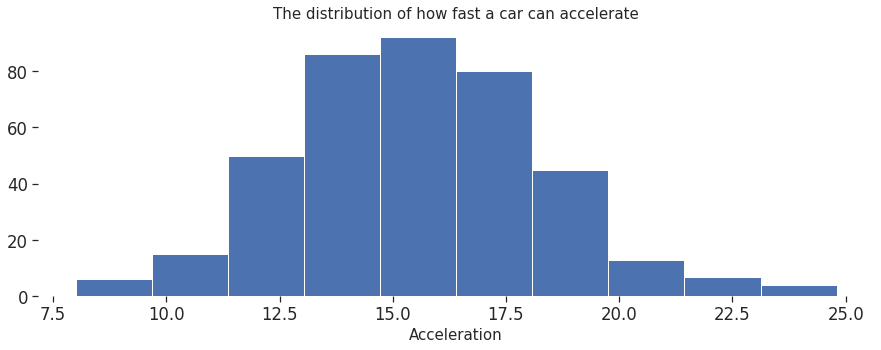

In [ ]:
plt.figure(figsize=(15,5))
plt.hist(data["acceleration"])
sns.despine(trim= True, bottom=True, left=True)
plt.title("The distribution of how fast a car can accelerate", fontsize=15)
plt.xlabel("Acceleration", fontsize=15)
plt.show()

##### ***Bel-shaped distribution*** withh ***right tail longer that the left***, which means that we have less number of cars that can accelerate more faster.
###### Note, The "acceleration" variable is the time in seconds to accelerate from 0 to 60 miles per hour. Higher values indicate slower acceleration.
###### ***just acceleration is not a good indicator***.

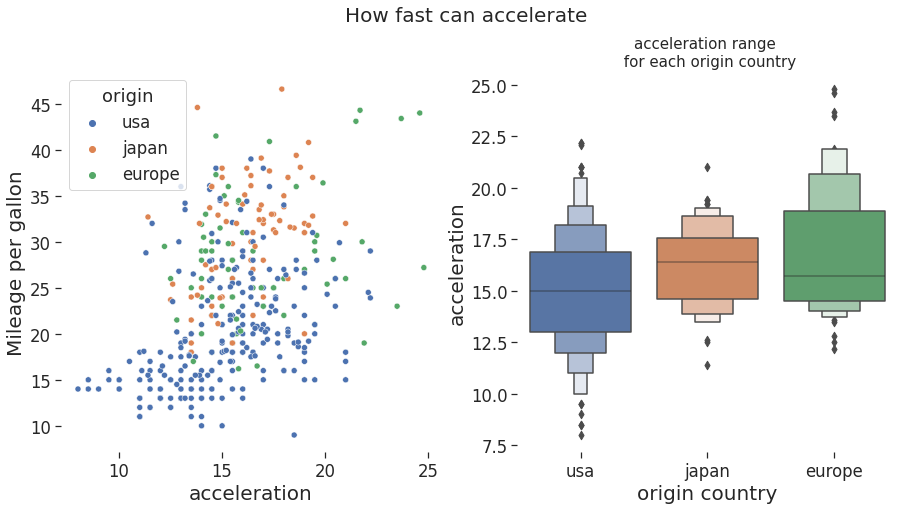

In [ ]:
plt.figure(figsize=(15,7))
plt.suptitle("How fast can accelerate", y=1.01, fontsize=20)

plt.subplot(1,2,1)
sns.scatterplot(data=data, x="acceleration", y="mpg",  hue="origin")
sns.despine(trim= True, bottom=True, left=True)
plt.ylabel("Mileage per gallon", fontsize=20)
plt.xlabel("acceleration", fontsize=20)

plt.subplot(1,2,2)
sns.boxenplot(x="origin", 
            y="acceleration", 
            data=data)
sns.despine(trim= True, bottom=True, left=True)
plt.title("acceleration range \n for each origin country", fontsize=15)
plt.ylabel("acceleration", fontsize=20)
plt.xlabel("origin country", fontsize=20)

plt.show()


#### This's graph is to emphasis that ***just acceleration is not a good indicator*** for how amount for a car can drive mileage per gallon.
#### The cars that can ***accelerate more faster*** is ***europe origin country***.

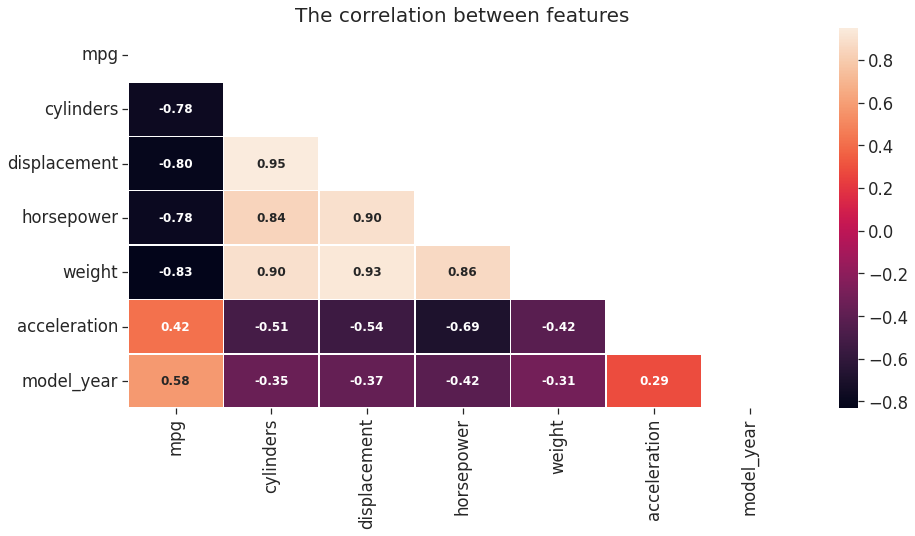

In [ ]:
plt.figure(figsize=(15,7))
corr = data.corr()
mask = np.triu(corr)
sns.heatmap(corr, linewidths=0.5, annot= True, mask= mask, cbar= True,
            fmt=".2f", annot_kws={"fontsize":12, "weight":'bold'}).set_facecolor('white')

plt.title("The correlation between features", y=1.02, fontsize=20)

plt.show()

#### We can observe that there's ***hight correlation*** between acceleration and horsepower. So, simply we're going to drope it. in order not to confuse the model.

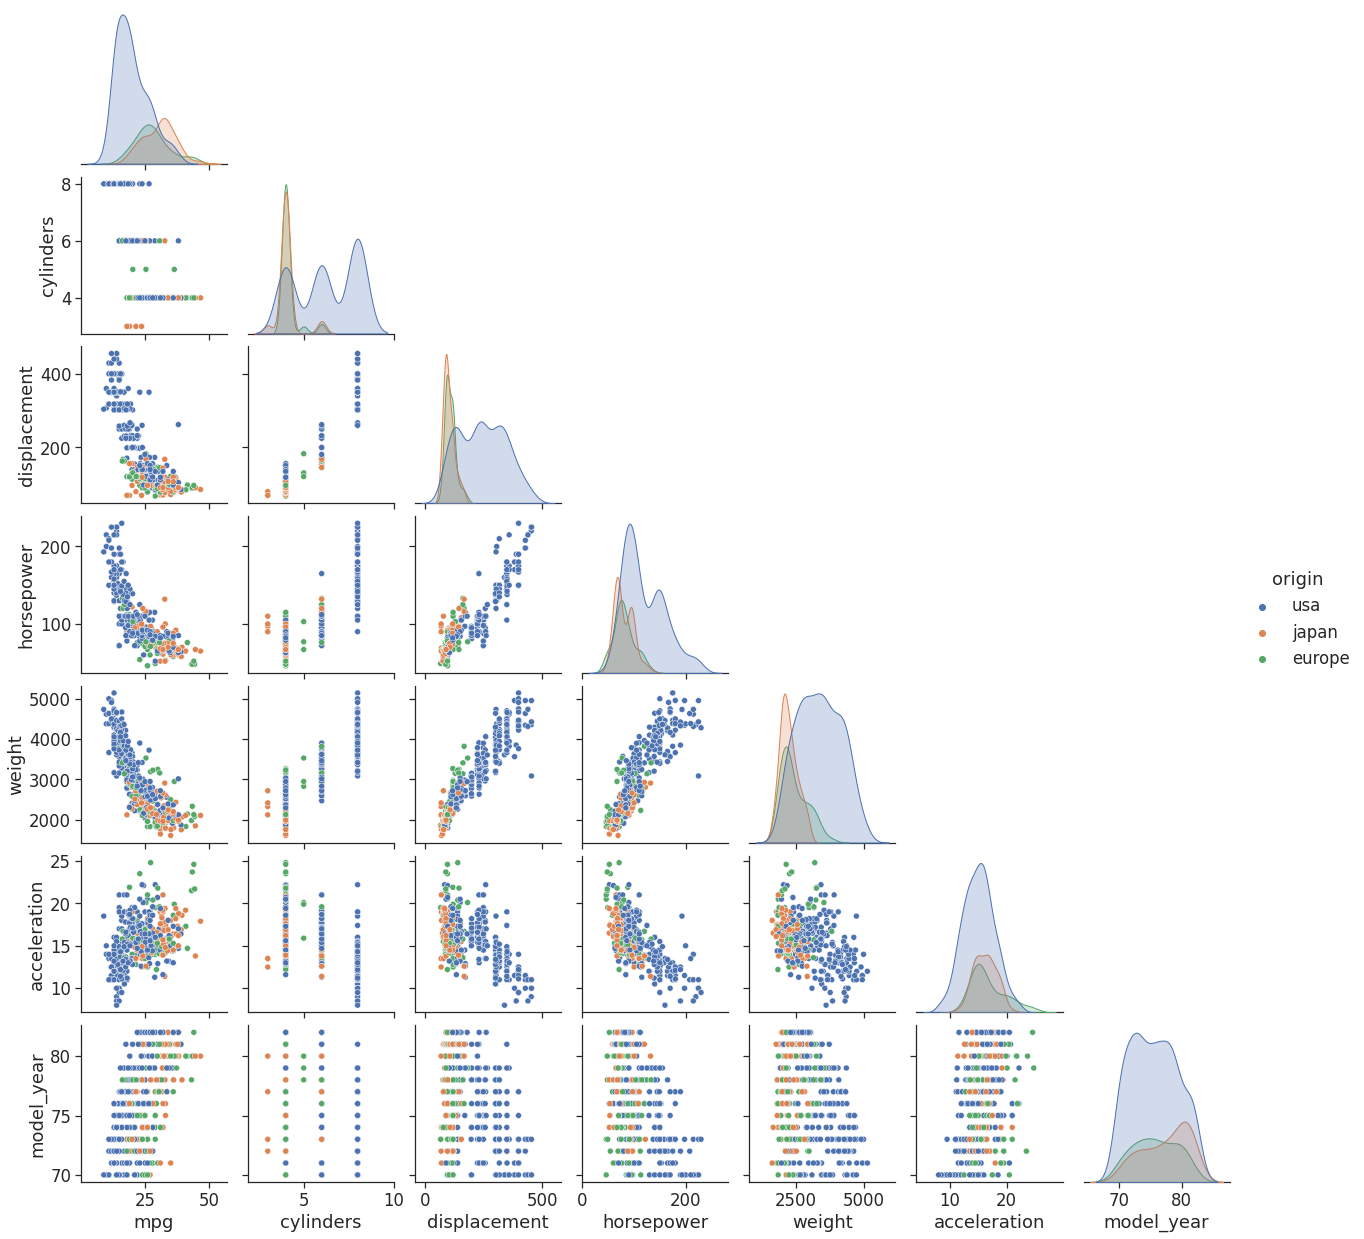

In [ ]:
sns.pairplot(data= data, hue="origin", corner=True) 
plt.show()

## ***Data cleaning***.

##### we can drop year colum as it makes no diffrence, in order not to confuse our machine learning model.

In [55]:
data.drop("model_year", axis=1, inplace=True)
data.shape

(398, 7)

We have to must reconsider that  we've 6 missingness in the horsepower column, for ***better intution*** and *better eye view* let's ***visualize missingness***.

In [36]:
# find out the exact samples with missingness in the horsepower column.
horse=data[data["horsepower"].isna()]
horse["origin"].value_counts()

usa       4
europe    2
Name: origin, dtype: int64

##### ***4 samples with usa origin country and 2 samples with europe***

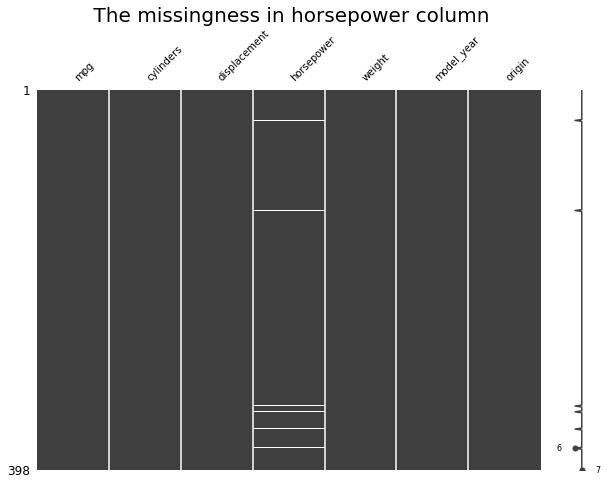

In [ ]:
msno.matrix(data, figsize=(10,7), fontsize=10)
plt.title(" The missingness in horsepower column", fontsize=20)
plt.show()

As we can observe, The missingness are *completely-random*, as it's ***randomly ditributed***. So, let's replace missingness with the value of the nearst point in our dataset. ***based_model imputation***
<br> But first, let's map the ***origin country name*** with ***numbers***. So, our model can iterpret. as LinearRegression require numerical variables.

In [37]:
#mapping={"usa":1, "japan":2, "europe":3}
#data["origin"] = data["origin"].map(mapping).astype("int")
#data.head()

In [113]:
data= pd.get_dummies(data, columns=["origin"])
data.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin_europe,origin_japan,origin_usa
0,18.0,8,307.0,130.0,3504,12.0,70,0,0,1
1,15.0,8,350.0,165.0,3693,11.5,70,0,0,1
2,18.0,8,318.0,150.0,3436,11.0,70,0,0,1
3,16.0,8,304.0,150.0,3433,12.0,70,0,0,1
4,17.0,8,302.0,140.0,3449,10.5,70,0,0,1


In [114]:
# We import KnnImputer, Now define an object from KNNImputer class called imputer.
imputer = KNNImputer(n_neighbors=5)
# fit & transform the dataset to fill missigness with the nearst neighbor.
data.iloc[:, :] = imputer.fit_transform(data)
#chech for missingness.
data.isna().sum()

mpg              0
cylinders        0
displacement     0
horsepower       0
weight           0
acceleration     0
model_year       0
origin_europe    0
origin_japan     0
origin_usa       0
dtype: int64

#### Let's split our dataset into two parts, the first part is ***target part*** (dependent variable). which we want to estimate which is Mileage per gallon ***mpg*** in this case, and ***features part*** which the features of the car or (the independent variables) we help us determine the target.

In [115]:
y=data["mpg"]
x=data.drop("mpg", axis=1)
print("The independent variables or features for the car  shape is:", x.shape)
print("The target we wnat to estimate shape is:", y.shape)

The independent variables or features for the car  shape is: (398, 9)
The target we wnat to estimate shape is: (398,)


#### Now, Let's split our dataset into trainig and testing. 

In [116]:
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.2, random_state=40, shuffle=True)

#### Now, we're going to use LinearRegression model

In [117]:
LR=LinearRegression()

LR.fit(x_train, y_train)
prediction = LR.predict(x_test)

print('MAE:', mean_absolute_error(y_test, prediction))

MAE: 2.387769430705314


##### we'll try anther machine learning algorithm called RandomForestRegressor, in order to reduce the mean error with our predictive model.

In [120]:
RF_model = RandomForestRegressor()
RF_model.fit(x_train,y_train)

prediction = RF_model.predict(x_test)
print('MAE:', mean_absolute_error(y_test, prediction))

MAE: 1.595524999999999


### Hyper-parameter tuning.

In [122]:
# Number of trees in random forest
#n_estimators = [int(x) for x in np.linspace(start = 200, stop = 1000, step = 5)]
n_estimators= range(200, 1000, 5)
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
#max_depth = [int(x) for x in np.linspace(10, 200, step = 3)]
max_depth= range(10, 200, 3)
# Minimum number of samples required to split a node
min_samples_split = range(2, 15)
# Minimum number of samples required at each leaf node
min_samples_leaf = range(2, 15)
random_state=np.arange(0,20, 1)

In [123]:
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'random_state': random_state}

In [105]:
from sklearn.model_selection import RandomizedSearchCV

In [125]:
Rf_cv = RandomizedSearchCV(RF_model, random_grid, n_iter=100, cv=5)
Rf_cv.fit(x_train, y_train)
predictions= Rf_cv.predict(x_test)

In [126]:
Rf_cv.best_params_

{'max_depth': 166,
 'max_features': 'auto',
 'min_samples_leaf': 2,
 'min_samples_split': 8,
 'n_estimators': 715,
 'random_state': 5}

In [127]:
mean_absolute_error(y_test, predictions)

1.6672872822118527

It semms that tuning hyperparmeters does not make any defferences, we'll try anther model callled XGBoost.

In [88]:
import xgboost as xgb

In [109]:
XGB_model= xgb.XGBRegressor(objective ='reg:linear',
                  n_estimators = 200, seed = 123)
XGB_model.fit(x_train, y_train)
XGB_predictions = XGB_model.predict(x_test)

[17:49:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [110]:
mean_absolute_error(y_test, XGB_predictions)

1.6421395802497862